# Binary Classification

k-Nearest Neighbour is a classifier that can learn the decision boundary between interictal and preictal segments. Spectral power bands extracted from raw EEG signal is used as input and a target label is specified alongside. We use the following convention for target label:

- 0: interictal segment
- 1: preictal segment

In [1]:
import os
import re
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler 
import matplotlib.pyplot as plt

In [2]:
data_dir = '/Volumes/My Passport/AI_Research/data/'
patient_names = [name for name in next(os.walk(data_dir))[1]
                 if name != '.ipynb_checkpoints' 
                 if name != 'Patient_1' 
                 if name != 'Patient_2']
patient_names

['Dog_1', 'Dog_2', 'Dog_3', 'Dog_4', 'Dog_5']

## Load data matrix and target vector

In [3]:
for i in range(len(patient_names) - 4):
    patient_name = patient_names[i]
    files_dir = data_dir + patient_name + '/' + 'Power_In_Band_Features' + '/'
    patient_files = os.listdir(files_dir)
    interictal_features = []
    preictal_features = []
    for j in tqdm(range(len(patient_files)), desc=patient_name):
        patient_file_name = patient_files[j]
        h5_path = files_dir + patient_file_name
        if not re.findall('_test_segment_', patient_file_name):
            with h5py.File(h5_path, "r") as f:
                group_key = list(f.keys())[0]
                data = np.array(f.get(group_key))
            if re.findall('_interictal_segment_', patient_file_name):
                interictal_features.append(data.flatten())
            if re.findall('_preictal_segment_', patient_file_name):
                preictal_features.append(data.flatten())    
    interictal_ys = np.zeros((len(interictal_features),))
    preictal_ys = np.ones(len(preictal_features))
    
    interictal_features = np.stack(interictal_features, axis=0)
    preictal_features = np.stack(preictal_features, axis=0)
    
    X = np.vstack((interictal_features, preictal_features))
    y = np.concatenate((interictal_ys, preictal_ys), axis=0)

Dog_1: 100%|██████████| 504/504 [00:22<00:00, 22.77it/s]


In [4]:
print('X:', X.shape)
print('y:', y.shape)

X: (504, 96)
y: (504,)


## Tackling class imbalance

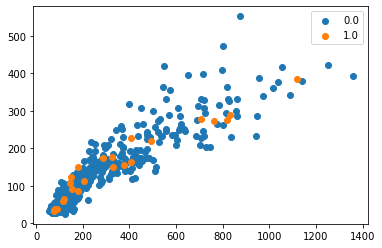

Counter({0.0: 480, 1.0: 24})


In [5]:
# visualise class scatter
counter = Counter(y)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()
print(counter)

### Undersampling

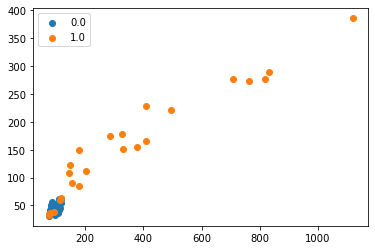

Counter({0.0: 24, 1.0: 24})


In [6]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=5)
# transform the dataset
X_under, y_under = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_under)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_under == label)[0]
    plt.scatter(X_under[row_ix, 0], X_under[row_ix, 1], label=str(label))
plt.legend()
plt.show()
print(counter)

### Oversampling

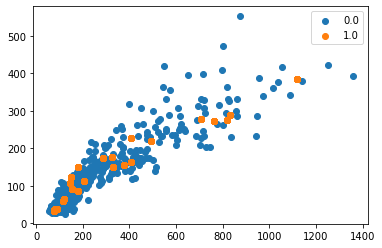

Counter({0.0: 480, 1.0: 480})


In [7]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_over)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y_over == label)[0]
    plt.scatter(X_over[row_ix, 0], X_over[row_ix, 1], label=str(label))
plt.legend()
plt.show()
# summarize class distribution
print(Counter(y_over))

## Create validation set

We create 3 validation sets, first from the imbalananced data, second from the undersampled interictal class and third from oversampled preictal class.

In [8]:
# imbalanced class
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
print(X_train.shape)
print(X_val.shape)

(337, 96)
(167, 96)


In [10]:
# undersampled class
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_under, y_under, test_size=0.33, 
                                                                         random_state=42)

In [11]:
print(X_train_under.shape)
print(X_val_under.shape)

(32, 96)
(16, 96)


In [12]:
# oversampled class
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_over, y_over, test_size=0.33,
                                                                     random_state=42)

In [13]:
print(X_train_over.shape)
print(X_val_over.shape)

(643, 96)
(317, 96)


## Fit model

In [14]:
# hyperparameter
k = 3
target_names = ['Interictal', 'Preictal']

In [15]:
# imbalanced class
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)
y_preds = knn.predict(X_val)

acc = accuracy_score(y_val, y_preds)
print('Imbalanced class')
print(classification_report(y_val, y_preds, target_names=target_names))

Imbalanced class
              precision    recall  f1-score   support

  Interictal       0.94      1.00      0.97       157
    Preictal       0.00      0.00      0.00        10

    accuracy                           0.94       167
   macro avg       0.47      0.50      0.48       167
weighted avg       0.88      0.94      0.91       167



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# undersampled class
knn_under = KNeighborsClassifier(n_neighbors=k)
knn_under.fit(X_under, y_under)
y_preds_under = knn.predict(X_val_under)

acc_under = accuracy_score(y_val_under, y_preds_under)

print('Undersampled class')
print(classification_report(y_val_under, y_preds_under, target_names=target_names))

Undersampled class
              precision    recall  f1-score   support

  Interictal       0.50      1.00      0.67         7
    Preictal       1.00      0.22      0.36         9

    accuracy                           0.56        16
   macro avg       0.75      0.61      0.52        16
weighted avg       0.78      0.56      0.50        16



In [17]:
# oversampled class
knn_over = KNeighborsClassifier(n_neighbors=k)
knn_over.fit(X_over, y_over)
y_preds_over = knn.predict(X_val_over)

acc_over = accuracy_score(y_val_over, y_preds_over)
print('Oversampled class')
print(classification_report(y_val_over, y_preds_over, target_names=target_names))

Oversampled class
              precision    recall  f1-score   support

  Interictal       0.53      1.00      0.69       157
    Preictal       1.00      0.13      0.23       160

    accuracy                           0.56       317
   macro avg       0.77      0.57      0.46       317
weighted avg       0.77      0.56      0.46       317



## Cross-validation and hyperparameter tuning

Max accuracy: 0.95


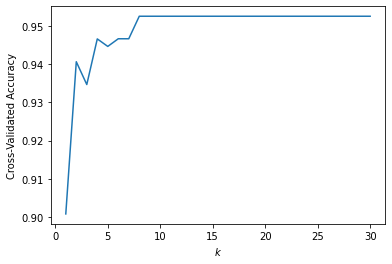

In [18]:
# 10-fold cross-validation with k=3 for k-NN
knn = KNeighborsClassifier(n_neighbors=5)

k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# fit the grid with data
grid.fit(X, y)

grid_mean_scores = grid.cv_results_['mean_test_score']
plt.plot(k_range, grid_mean_scores)
plt.xlabel(r'$k$')
plt.ylabel('Cross-Validated Accuracy')

print('Max accuracy: {max_acc:.2f}'.format(max_acc = np.max(grid_mean_scores)))